# Customer segmentation

In this notebook, we are going to divide the customers of a mall into clusters to be able to target them with accurate products.

In [64]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans

In [65]:
customer_data = pd.read_csv('customer-segmentation-dataset/Mall_Customers.csv')
customer_data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [52]:
#Data observation
pp.ProfileReport(customer_data.drop(["CustomerID"],axis=1), title="Rapport")

Summarize dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [66]:
customer_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


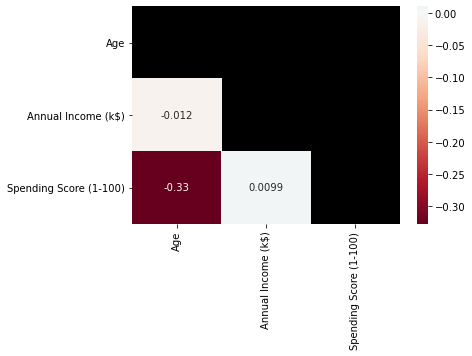

In [67]:
#Let's look at the correlation of numerical data

cor_data = customer_data.drop(['CustomerID'],axis=1).corr()
mask = np.transpose(np.tril(np.ones(cor_data.shape)))
sns.heatmap(cor_data, annot = True, center = 0, cmap = 'RdBu', mask = mask);

It seems like the youngest people are the one spending the more !

In [96]:
#Encoding gender

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

cust_data_copy = customer_data

gender_cols =  pd.DataFrame(encoder.fit_transform(cust_data_copy["Gender"].values.reshape(-1,1)))

gender_cols.index = cust_data_copy.index

cust_data_copy = cust_data_copy.drop(["Gender"], axis=1)

cust_data_copy = pd.concat([cust_data_copy, gender_cols], axis=1)

cust_data_copy

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),0,1
0,1,19,15,39,0.0,1.0
1,2,21,15,81,0.0,1.0
2,3,20,16,6,1.0,0.0
3,4,23,16,77,1.0,0.0
4,5,31,17,40,1.0,0.0
...,...,...,...,...,...,...
195,196,35,120,79,1.0,0.0
196,197,45,126,28,1.0,0.0
197,198,32,126,74,0.0,1.0
198,199,32,137,18,0.0,1.0


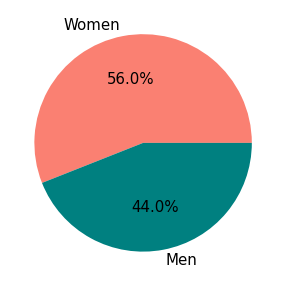

In [97]:
#Let's look at the population's gender

men = customer_data[customer_data['Gender']=='Male'].count()[0]
women = customer_data['CustomerID'].size - men

fig, ax = plt.subplots(figsize=(5, 5))
pie = ax.pie([women,men],
             labels=["Women", "Men"],
             colors=["salmon", "teal"],
             textprops={"fontsize": 15},
             autopct='%1.1f%%')

# K-clustering

<h3>We now have to determine the optimal number of cluster we want, for this, we want to minimize intra-cluster variation</h3>
<n>
<b>
We're going to search this optimal number through two different methods

# 1. Elbow method

In [98]:
int_clust_var = []
axis = []
for k in range(1,10):
    kmeans = KMeans(n_clusters=k).fit(cust_data_copy.T.loc[["Age","Annual Income (k$)","Spending Score (1-100)",0,1]].T)
    int_clust_var.append(kmeans.inertia_)
    axis.append(k)

Text(0.5, 0, 'number of clusters')

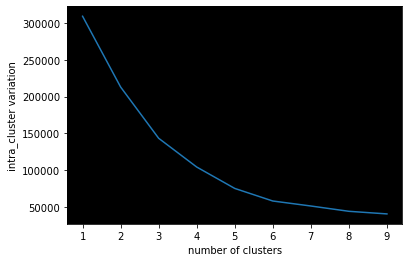

In [71]:
plt.plot(axis,int_clust_var)
plt.ylabel("intra_cluster variation")
plt.xlabel('number of clusters')

We can see on the graph that the elbow is around 4. We should choose something around 4

# 2. Average Silhouette Method

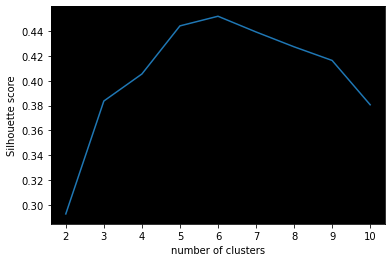

In [72]:
ax=[]
scores=[]
for k in range(2,11):
    clustering_data = cust_data_copy.T.loc[["Age","Annual Income (k$)","Spending Score (1-100)",0,1]].T
    kmeans = KMeans(n_clusters=k).fit(clustering_data)
    labels = kmeans.labels_
    ax.append(k)
    score = silhouette_score(clustering_data,
                    labels,
                    metric='euclidean')
    scores.append(score)
plt.plot(ax,scores)
plt.ylabel('Silhouette score')
plt.xlabel('number of clusters')
plt.show()

The maximum width is at 6 clusters, we are going to take this option

# Clusters visualisation


First, let's look at the distribution with vectors (the principal components)

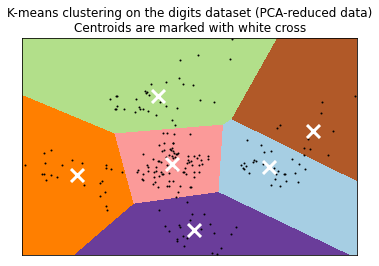

In [90]:
pca = PCA(n_components = 2)

reduced_data = pca.fit_transform(clustering_data)

kmeans = KMeans(n_clusters=6).fit(reduced_data)

h = .02

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation="nearest",
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired, aspect="auto", origin="lower")

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
            color="w", zorder=10)
plt.title("K-means clustering on the digits dataset (PCA-reduced data)\n"
          "Centroids are marked with white cross")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [91]:
pca.components_

array([[-1.88980385e-01,  5.88604475e-01,  7.86022241e-01,
         3.32880772e-04, -3.32880772e-04],
       [ 1.30957602e-01,  8.08400899e-01, -5.73875514e-01,
        -1.57927017e-03,  1.57927017e-03]])

We can see that the two most impactfull features (by calculating L2 norms of pca.components) are the 2nd and the 3rd ie the Annual income and the Spending score.

<AxesSubplot:title={'center':'Customer clusters according to Annual Income and Spending Score'}, xlabel='Annual Income (k$)', ylabel='Spending Score (1-100)'>

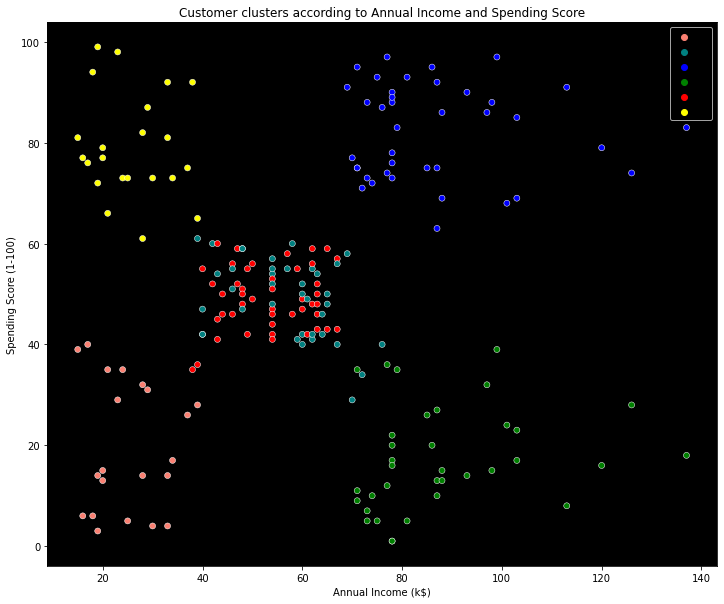

In [93]:
# Plotting with axes representing the two most important features

plt.rcParams['axes.facecolor'] = 'black'

kmeans = KMeans(n_clusters=6).fit(clustering_data)

income = clustering_data["Annual Income (k$)"]
spending = clustering_data["Spending Score (1-100)"]
hue = kmeans.predict(clustering_data)

plt.figure(figsize = (12,10))
plt.title("Customer clusters according to Annual Income and Spending Score")
sns.scatterplot(x=income, y=spending, hue=hue,palette=["salmon", "teal", "blue", "green", "red", "yellow"])

We can conclude by saying that the dataset can be clustered into 6 different class of clients, 5 being defined by their annual income and spending score.

The class of the ones who have :
- Low Income & low Spending Score (5)
- Low Income but high Spending Score (1)
- Medium Income & medium Spending Score (0 and 3)
- High Income but low Spending Score (4)
- High Income & high Spending Score (2)

We can base our strategy on this distribution of clients, because it allows us to guess the type of product they could buy (Annual Income is an indicator of the social class they belong, therefore an indicator of their spending habits) and the amount of money they are ready to invest in the mall (Spending Score)
